In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [2]:
df = pd.read_csv("bitcoin.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

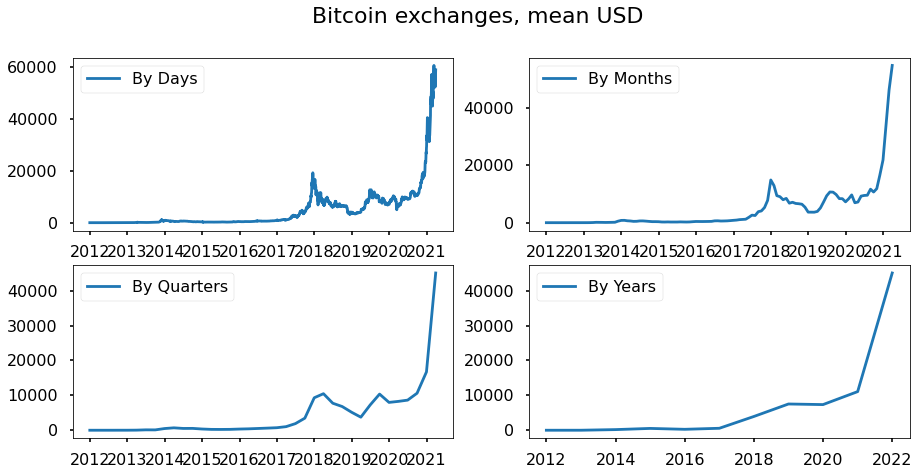

In [5]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df['Weighted_Price'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month['Weighted_Price'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q['Weighted_Price'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year['Weighted_Price'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

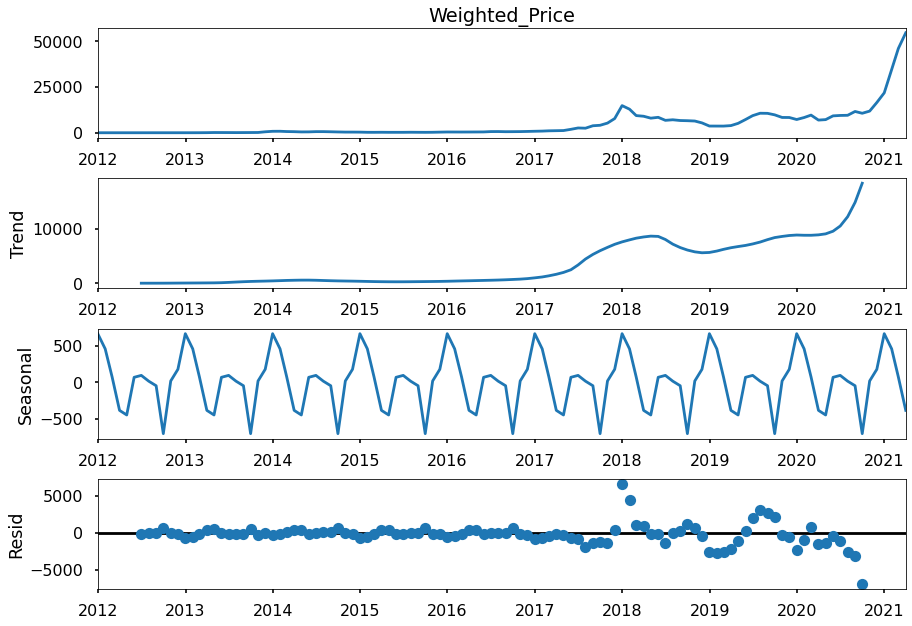

In [6]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month['Weighted_Price']).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['Weighted_Price'])[1])
plt.show()

In [7]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month['Weighted_Price'])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['Weighted_Price'])[1])

Dickey–Fuller test: p=0.998863


In [22]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

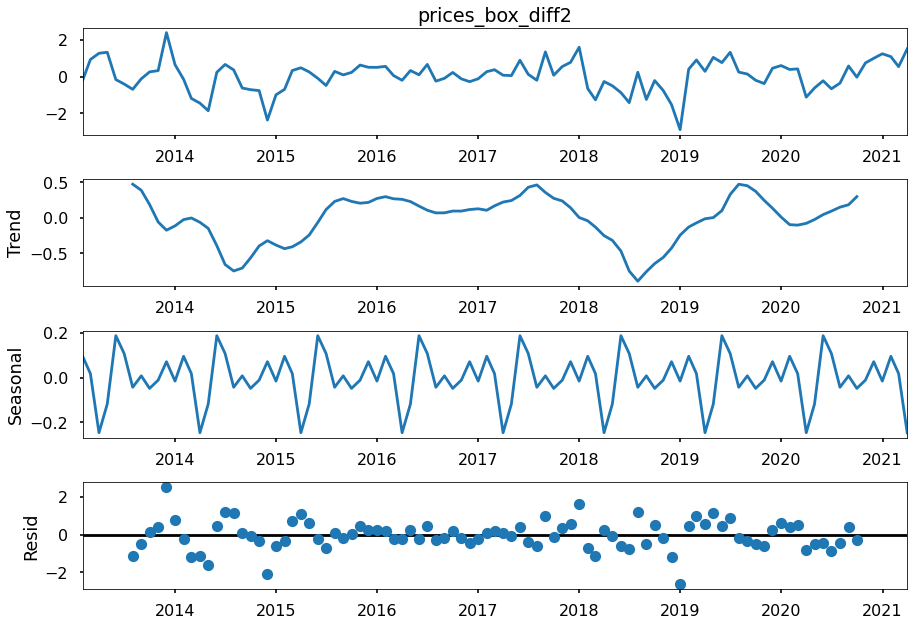

In [9]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

Now we need to make model selection, with help of :

Autocorrelation Function (ACF):
The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.

Partial Autocorrelation Function (PACF):
The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations. We can get a basic picture of the parameter interval, and using this heuristic we can with help of AIC- Akaike information criterion decide which are the best p,q,d for ARIMA.

Parameters are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

In [25]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.617135
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547346
37  (2, 0, 0, 1)  175.554620
7   (0, 1, 0, 1)  175.589729
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.809
Date:                              Mon, 06 Dec 2021   AIC                            173.617
Time:                                      12:31:31   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.767
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

In [12]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

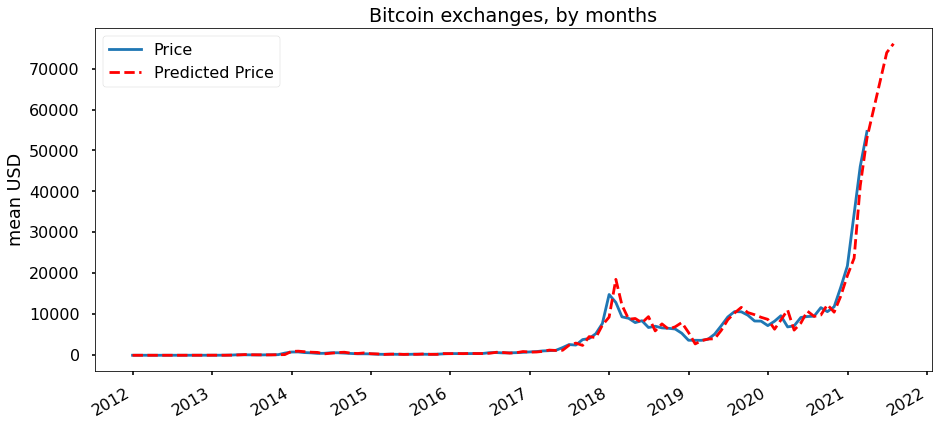

In [77]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 6, 30), datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30), 
             datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31), datetime(2022, 1, 31),
             datetime(2022, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=115), lmbda)
plt.figure(figsize=(15,7))
df_month2['Weighted_Price'].plot(label='Price')
df_month2.forecast.plot(color='r', ls='--', label='Predicted Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()